# Analyzing Reverting Behavior

## Load Data

Load data generated in https://github.com/digitalTranshumant/Wiki-examples/blob/master/Reverts%20from%20SHA1.ipynb 

In [5]:
import json
with open('interactions.json') as f:
    interactions = json.load(f)

In [2]:
!zcat revs_2017_users_more_than_10_revs.txt.gz |head

rev_page	rev_id	rev_user	rev_timestamp	rev_sha1
9118440	757663913	2	20170101001156	2f65qj120urwp044eeo6j2rm3wd1h1u
49594522	757663027	1398	20170101000338	jx8qoktaz5zf5pzjda36m2dayjv8w58
25861593	757663628	1398	20170101000912	1pvsqbrkexkw3wzshohr5dao3fqi342
42218528	757662647	15708	20170101000026	6pnic47lnqd2x8gqv40gansh07tq4oa
42218528	757663085	15708	20170101000412	gbo5zumq3humr7lbvs6658pxhiysaa8
42218528	757663200	15708	20170101000514	npu039arvt9c181iabsq779v2fb881k
42218528	757663606	15708	20170101000855	dyidazvzelaja3egc8yeq3c8uz1251l
42218528	757663773	15708	20170101001039	g2kzlydsus443qyd1nd5qqacv4yvp97
42218528	757663831	15708	20170101001113	nihfgc9ujuzu54pbcf1ykzcvymj9e3l

gzip: stdout: Broken pipe


### Get the number of revision per user, using awk (faster than using pandas)

In [3]:
!zcat revs_2017_users_more_than_10_revs.txt.gz | awk '{print $3}'| sort | uniq -c > revsPerUser.txt

In [4]:
!head revsPerUser.txt

     55 1
     50 100
     91 10000146
     22 10000400
     15 10000749
   3985 10000761
   1040 10001499
    113 10001880
     11 10002
    109 10002430


In [9]:
f = open('revsPerUser.txt')
revsPerUser = {}
for l in f:
    count,userid = l.split()
    revsPerUser[userid] = int(count)
f.close()

Compute the number of revisions that were reverts. Note that this step is necesary to consider each revision only one time, even if that revision reverts many other revisions

In [10]:
revertsPerUser = {} #number of times that user reverted others 
for user,data in interactions.items():
    r = {}
    for user2,reverts in data.items():
        if user != user2: #not considering self reverts
            for info in reverts:
                r[info[3]]=''
    revertsPerUser[user] = len(r)

In [11]:
revertedPerUser = {}
for user,data in interactions.items():
    for user2,reverts in data.items():
        r = {}
        if user2!=user: #not considering autoreverts
            for info in reverts:
                r[info[4]] =''
            revertedPerUser[user2] = revertedPerUser.get(user2,{})
            revertedPerUser[user2] = {**revertedPerUser[user2],**r} #merge two dictionaries, explanation here
            
for user,revs in revertedPerUser.items():
    revertedPerUser[user] = len(revs)

* revsPerUser: # of revisions (activity)
* revertsPerUser: # of reverts done
* revertedPerUser: # of reverts received 


## Reverts Done vs activity 

SpearmanrResult(correlation=0.41072013403003726, pvalue=0.0)
Pearson (logaratimic values) (0.64793341760252388, 0.0)


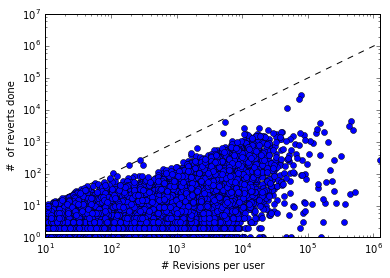

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr

x_reverts,y_reverts = [],[]
for user,revs in revsPerUser.items():
    x_reverts.append(revs)
    y_reverts.append(revertsPerUser.get(user,0))

plt.plot( [10,max(x_reverts)],[10,max(x_reverts)],'k--' ) #plot identity
plt.loglog(x_reverts,y_reverts,'o')
plt.xlabel('# Revisions per user')
plt.ylabel('#  of reverts done')
plt.xlim([10,max(x_reverts)])
print(spearmanr(x_reverts,y_reverts))
print('Pearson (logaratimic values)',pearsonr([np.log(a) for a in x_reverts],[np.log(a+1) for a in y_reverts]))

SpearmanrResult(correlation=0.34818842073461126, pvalue=0.0)
Pearson ( logaratimic values for x) (0.019319949399250465, 4.5759464365573026e-12)


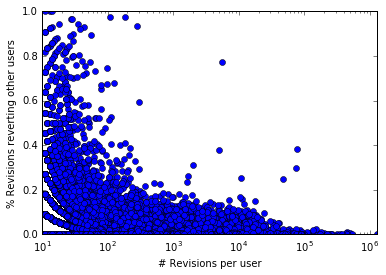

In [54]:
usersPercentOfReverts = {} # percentage of revisions that are reverts to others
x_reverts,y_reverts_perecent = [],[]
for user,revs in revsPerUser.items():
    if revertsPerUser.get(user,0) > revs:
        print('here',user,revertsPerUser.get(user,0),revs)
        break
    x_reverts.append(revs)
    y_reverts_perecent.append(revertsPerUser.get(user,0)/revs)
    usersPercentOfReverts[user] = revertsPerUser.get(user,0)/revs
plt.semilogx(x_reverts,y_reverts_perecent,'o')
plt.xlim([10,max(x_reverts)])
plt.xlabel('# Revisions per user')
plt.ylabel('% Revisions reverting other users')
print(spearmanr(x_reverts,y_reverts_perecent))
print('Pearson ( logaratimic values for x)',pearsonr([np.log(a) for a in x_reverts],y_reverts_perecent))
with open('usersPercentOfReverts.json','w') as f:
    json.dump(usersPercentOfReverts,f)

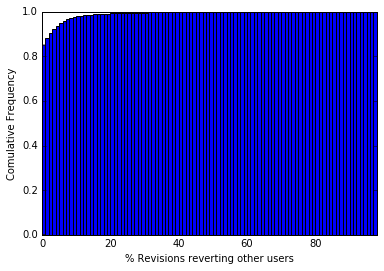

In [196]:
import numpy as np
plt.hist(list(map(lambda p: 100*p[0]/p[1],zip(y_reverts,x_reverts))),bins=np.arange(0.0,100,1), normed=1,cumulative=1)
#plt.yscale('log')
plt.xlim([0,98])
plt.ylabel('Comulative Frequency')
plt.xlabel('% Revisions reverting other users')


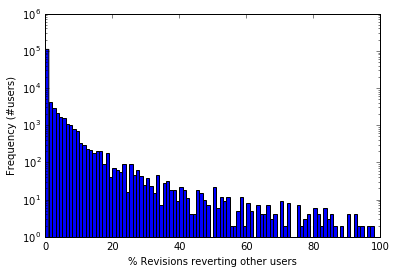

In [187]:
import numpy as np
plt.hist(list(map(lambda p: 100*p[0]/p[1],zip(y_reverts,x_reverts))),bins=np.arange(0.0,100,1),)
plt.yscale('log')
plt.ylabel('Frequency (#users)')
plt.xlabel('% Revisions reverting other users')


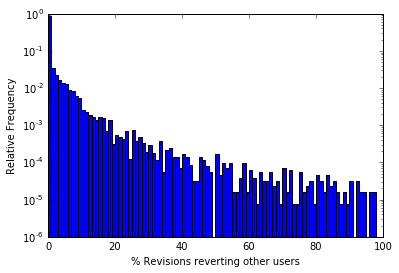

In [25]:
import numpy as np
plt.hist(list(map(lambda p: 100*p[0]/p[1],zip(y_reverts,x_reverts))),bins=np.arange(0.0,100,1),normed=1)
plt.yscale('log')
plt.ylabel('Relative Frequency')
plt.xlabel('% Revisions reverting other users')


In [51]:
a,b = np.histogram(list(map(lambda p: 100*p[0]/p[1],zip(y_reverts,x_reverts))),bins=np.arange(0.0,100,1),normed=1)
cumulative = 0
print('bin','freq','cumulative')
for n,p in enumerate(a):
    cumulative += p
    print(b[n],p,cumulative)

bin freq cumulative
0.0 0.849928626588 0.849928626588
1.0 0.0334870006786 0.883415627267
2.0 0.0225430775591 0.905958704826
3.0 0.0161467718157 0.922105476642
4.0 0.013330837214 0.935436313856
5.0 0.0125273988097 0.947963712665
6.0 0.00857260977075 0.956536322436
7.0 0.00814358926357 0.9646799117
8.0 0.00604528896481 0.970725200665
9.0 0.00531205391618 0.976037254581
10.0 0.00255852229737 0.978595776878
11.0 0.00222310626448 0.980818883143
12.0 0.00184088799445 0.982659771137
13.0 0.00163027792728 0.984290049064
14.0 0.00140406711441 0.985694116179
15.0 0.00162247755443 0.987316593733
16.0 0.00158347569014 0.988900069423
17.0 0.000694233184346 0.989594302608
18.0 0.00141186748727 0.991006170095
19.0 0.000319815287171 0.991325985382
20.0 0.00053822572719 0.991864211109
21.0 0.000475822744327 0.992340033854
22.0 0.000421220134322 0.992761253988
23.0 0.000686432811488 0.993447686799
24.0 0.000124805965725 0.993572492765
25.0 0.000725434675778 0.994297927441
26.0 0.000366617524318 0.994664

## Reverts Received vs Activity 

SpearmanrResult(correlation=0.34676828594403264, pvalue=0.0)
(0.23610092788226719, 0.0)


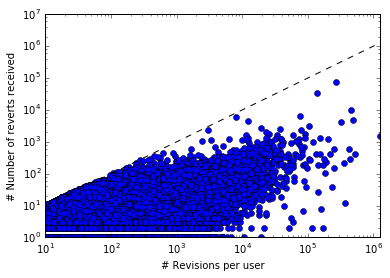

In [21]:
x_reverted,y_reverted = [],[]
for user,revs in revsPerUser.items():
    if revertedPerUser.get(user,0) >revs:
        print(revs,revertedPerUser.get(user,0),user)
    x_reverted.append(revs)
    y_reverted.append(revertedPerUser.get(user,0))
    
plt.loglog(x_reverted,y_reverted,'o')

plt.xlabel('# Revisions per user')
plt.ylabel('# Number of reverts received')
plt.plot( [10,max(x_reverted)],[10,max(x_reverted)],'k--' )
plt.xlim([10,max(x_reverted)])

print(spearmanr(x_reverted,y_reverted))
print(pearsonr(x_reverted,y_reverted))

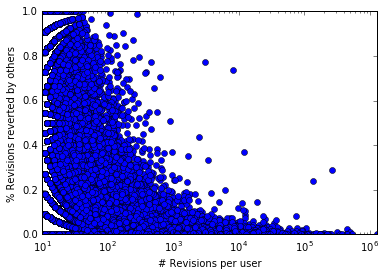

In [20]:
x_reverted,y_reverted_perecent = [],[]
for user,revs in revsPerUser.items():
    x_reverted.append(revs)
    y_reverted_perecent.append(revertedPerUser.get(user,0)/revs)
    
plt.semilogx(x_reverted,y_reverted_perecent,'o')
plt.xlim([10,max(x_reverted)])
plt.xlabel('# Revisions per user')
plt.ylabel('% Revisions reverted by others')


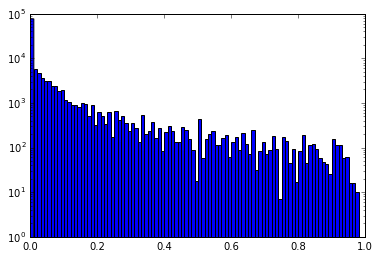

In [154]:
import numpy as np
plt.hist(list(map(lambda p: p[0]/p[1],zip(y_reverted,x_reverted))),bins=np.arange(0.0,1,0.01))
plt.yscale('log')
 

# Reverts done versus received

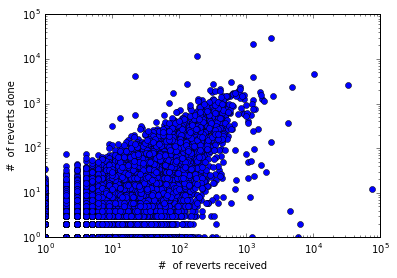

In [155]:
x,y = [],[]
for user in revertedPerUser.keys() & revertsPerUser.keys():
    x.append(revertedPerUser[user])
    y.append(revertsPerUser[user])
plt.loglog(x,y,'o')

plt.xlabel('#  of reverts received' )
plt.ylabel('#  of reverts done')

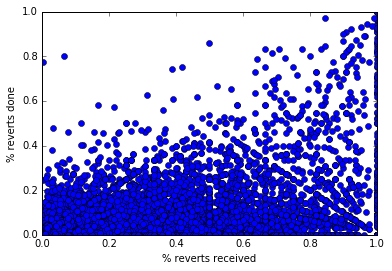

In [199]:
x,y = [],[]
for user in revertedPerUser.keys() & revertsPerUser.keys():
    x.append(revertedPerUser[user]/revsPerUser[user])
    y.append(revertsPerUser[user]/revsPerUser[user])
plt.plot(x,y,'o')
plt.xlabel('% reverts received' )
plt.ylabel('% reverts done')

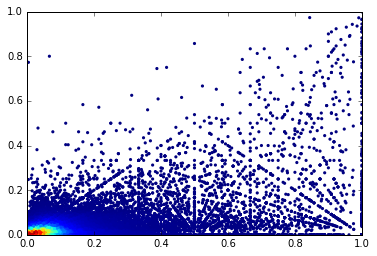

In [203]:
# Calculate the point density
from scipy.stats import gaussian_kde
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10, edgecolor='')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

## Number of users reverted

In [57]:
numberOfUsersReverted = {}
for user1,info in interactions.items():
    numberOfUsersReverted[user1] = len(info)


In [71]:
with open('numberOfUsersReverted.json','w') as f:
    json.dump(numberOfUsersReverted,f)

(array([  0.00000000e+00,   5.95358181e-01,   1.45110275e-01,
          6.99051120e-02,   4.00709523e-02,   2.53889554e-02,
          1.82937254e-02,   1.31005300e-02,   9.74525560e-03,
          7.03111643e-03,   6.19764062e-03,   5.42827834e-03,
          4.53068901e-03,   3.71858437e-03,   3.61172850e-03,
          3.65447085e-03,   2.94922209e-03,   2.56454095e-03,
          1.94477688e-03,   1.81654984e-03,   2.39357155e-03,
          1.96614806e-03,   1.58146692e-03,   1.62420927e-03,
          9.83074030e-04,   1.38912635e-03,   1.41049752e-03,
          1.19678578e-03,   1.26089930e-03,   1.17541460e-03,
          7.47991110e-04,   8.12104633e-04,   8.76218157e-04,
          7.05248760e-04,   8.54846982e-04,   6.41135237e-04,
          7.05248760e-04,   7.47991110e-04,   7.05248760e-04,
          5.12908189e-04,   4.70165840e-04,   7.69362284e-04,
          7.90733459e-04,   5.77021713e-04,   5.77021713e-04,
          5.34279364e-04,   4.48794666e-04,   4.06052317e-04,
        

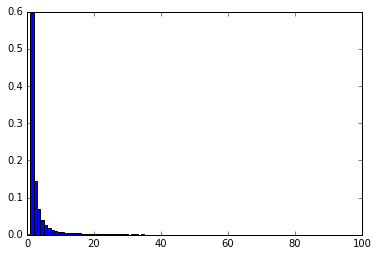

In [67]:
plt.close()
plt.hist(list(numberOfUsersReverted.values()),bins=list(range(0,100)),normed=1)

In [70]:
a,b =np.histogram(list(numberOfUsersReverted.values()),bins=list(range(0,100)),normed=1)
cumulative = 0
print('bin','freq','cumulative')
for n,p in enumerate(a):
    if cumulative > .90: break
    cumulative += p
    print(b[n],p,cumulative)

bin freq cumulative
0 0.0 0.0
1 0.595358180886 0.595358180886
2 0.145110275261 0.740468456146
3 0.069905111985 0.810373568131
4 0.0400709522995 0.850444520431
5 0.025388955377 0.875833475808
6 0.0182937254231 0.894127201231
7 0.0131005300051 0.907227731236
